In [ ]:
!pip install adversarial-robustness-toolbox --upgrade
!pip install numpy matplotlib scipy scikit-learn kymatio

In [ ]:
!pip install qiskit qiskit-aer qiskit-machine-learning --upgrade
!pip install qiskit-algorithms
!pip install --upgrade qiskit-machine-learning

  Using cached qiskit-1.3.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached qiskit_aer-0.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
  Using cached qiskit_machine_learning-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.4.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached pbr-6.1.0-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached qiskit-1.3.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.7 MB)
Using cached qiskit_aer-0.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
Using cached qiskit_machine_learning-0.8.1-py3-none-any.whl (231 kB)
Using cached dill-0.3.9-py3-none-any.whl (

# Wolfram Paper

https://uk.mathworks.com/help/radar/ug/radar-target-classification-using-machine-learning-and-deep-learning.html


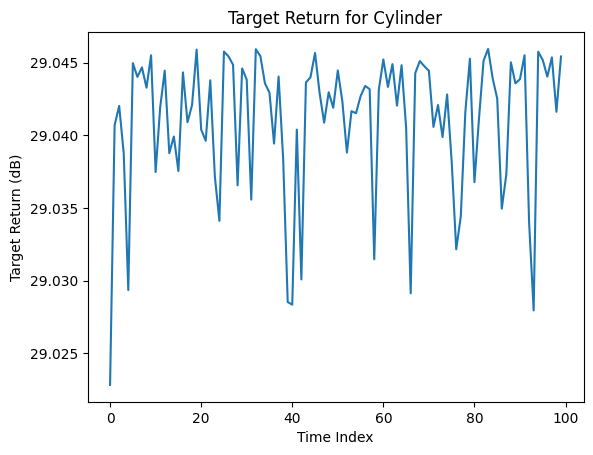

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8  # Speed of light in m/s
fc = 850e6  # Frequency in Hz
wavelength = c / fc

# Example RCS pattern simulation for a cylinder
def simulate_rcs(radius, height, azimuth, elevation):
    # Simplified RCS calculation (approximation)
    rcs = (radius * height) ** 2 / (wavelength ** 2)
    rcs_variation = np.cos(np.radians(azimuth)) * np.cos(np.radians(elevation))
    return rcs * rcs_variation

# Generate data
N = 100
azimuth = 2 * np.random.randn(N)
elevation = 2 * np.random.randn(N)
rcs_cylinder = simulate_rcs(1, 10, azimuth, elevation)

# Plot example
plt.plot(10 * np.log10(np.abs(rcs_cylinder)))
plt.xlabel("Time Index")
plt.ylabel("Target Return (dB)")
plt.title("Target Return for Cylinder")
plt.show()


In [ ]:
# Training Data
train_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]
train_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]

# Test Data
test_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]
test_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]


In [ ]:
from kymatio import Scattering1D

# Parameters
signal_length = 701
invariance_scale = 701
J = 6  # Number of wavelet scales
Q = 8  # Number of wavelets per octave

# Scattering Transform
scattering = Scattering1D(J=J, shape=(signal_length,), Q=Q)

# Apply scattering transform
features_train_cylinder = [scattering(profile) for profile in train_profiles_cylinder]
features_train_cone = [scattering(profile) for profile in train_profiles_cone]
features_test_cylinder = [scattering(profile) for profile in test_profiles_cylinder]
features_test_cone = [scattering(profile) for profile in test_profiles_cone]


SVM

Accuracy: 100.00%


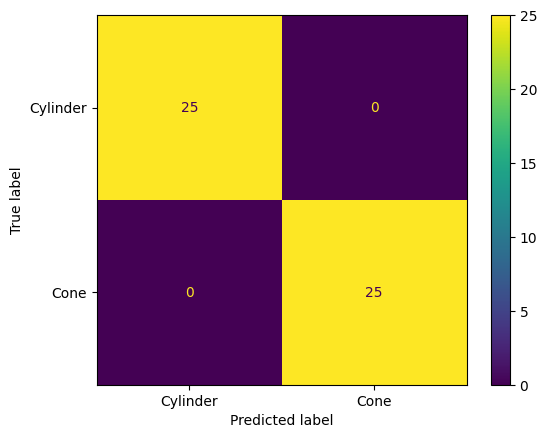

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Wrapper function to preprocess data
def preprocess_for_svm(features):
    # Flatten each sample if it's 3D
    return np.array([sample.flatten() for sample in features])

# Combine and label data, applying the preprocessing function
X_train = preprocess_for_svm(features_train_cylinder + features_train_cone)
y_train = np.array(['Cylinder'] * len(features_train_cylinder) + ['Cone'] * len(features_train_cone))

X_test = preprocess_for_svm(features_test_cylinder + features_test_cone)
y_test = np.array(['Cylinder'] * len(features_test_cylinder) + ['Cone'] * len(features_test_cone))

# Train SVM
svm = SVC(kernel='poly', degree=2, C=1, probability=True)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Cylinder', 'Cone'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cylinder', 'Cone'])
disp.plot()
plt.show()


Optimal Poisoning Attacks: Attackers craft specific malicious data points that,
when added to the training set, cause the SVM to produce a skewed decision boundary. This method often employs gradient-based techniques to determine the most impactful poisoning samples.

https://arxiv.org/pdf/1206.6389

unified framework

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import pickle
import pandas as pd

# Constants
c = 3e8  # Speed of light in m/s
fc = 850e6  # Frequency in Hz
wavelength = c / fc

# Example RCS pattern simulation for a cylinder
def simulate_rcs(radius, height, azimuth, elevation):
    rcs = (radius * height) ** 2 / (wavelength ** 2)
    rcs_variation = np.cos(np.radians(azimuth)) * np.cos(np.radians(elevation))
    return rcs * rcs_variation

# Generate and save data
def generate_and_save_data():
    # Training Data
    train_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]
    train_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]

    # Test Data
    test_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]
    test_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]

    data = {
        "train_cylinder": train_profiles_cylinder,
        "train_cone": train_profiles_cone,
        "test_cylinder": test_profiles_cylinder,
        "test_cone": test_profiles_cone
    }

    with open("dataset.pkl", "wb") as f:
        pickle.dump(data, f)

# Load data
def load_data():
    with open("dataset.pkl", "rb") as f:
        data = pickle.load(f)
    return data

# Wrapper function to preprocess data
def preprocess_for_svm(features):
    return np.array([sample.flatten() for sample in features])

# Poisoning function: Add small perturbations to the training data
def poison_data(X_train, y_train, epsilon=0.1, target_label='Cylinder'):
    X_poisoned = X_train.copy()
    y_poisoned = y_train.copy()

    # Identify indices of the target class to poison
    target_indices = np.where(y_train == target_label)[0]

    # Perturb the data for the target class
    for idx in target_indices:
        perturbation = epsilon * np.sign(np.random.randn(*X_train[idx].shape))
        X_poisoned[idx] += perturbation

    return X_poisoned, y_poisoned

# Main workflow
def main():
    generate_and_save_data()
    data = load_data()

    # Extract and preprocess data
    features_train_cylinder = data["train_cylinder"]
    features_train_cone = data["train_cone"]
    features_test_cylinder = data["test_cylinder"]
    features_test_cone = data["test_cone"]

    X_train = preprocess_for_svm(features_train_cylinder + features_train_cone)
    y_train = np.array(['Cylinder'] * len(features_train_cylinder) + ['Cone'] * len(features_train_cone))

    X_test = preprocess_for_svm(features_test_cylinder + features_test_cone)
    y_test = np.array(['Cylinder'] * len(features_test_cylinder) + ['Cone'] * len(features_test_cone))

    # Print original number of features
    print(f"Original number of features: {X_train.shape[1]}")

    # Apply PCA
    pca_components = 10  # Adjust this value to balance SVM and QSVM performance
    pca = PCA(n_components=pca_components)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    # Print reduced number of features
    print(f"Reduced number of features after PCA: {X_train_reduced.shape[1]}")

    # Normalize data for QSVM
    X_train_normalized = (X_train_reduced - np.min(X_train_reduced)) / (np.max(X_train_reduced) - np.min(X_train_reduced))
    X_test_normalized = (X_test_reduced - np.min(X_test_reduced)) / (np.max(X_test_reduced) - np.min(X_test_reduced))

    # Train SVM
    svm = SVC(kernel='poly', degree=2, C=1, probability=True)
    svm.fit(X_train_reduced, y_train)
    y_pred = svm.predict(X_test_reduced)
    accuracy_svm = accuracy_score(y_test, y_pred)
    precision_svm = precision_score(y_test, y_pred, pos_label='Cylinder', zero_division=0)
    recall_svm = recall_score(y_test, y_pred, pos_label='Cylinder', zero_division=0)
    f1_svm = f1_score(y_test, y_pred, pos_label='Cylinder', zero_division=0)

    # Poison data
    epsilon = 0.05
    X_train_poisoned, y_train_poisoned = poison_data(X_train_reduced, y_train, epsilon)

    # Train SVM with Poisoning
    svm_poisoned = SVC(kernel='poly', degree=2, C=1, probability=True)
    svm_poisoned.fit(X_train_poisoned, y_train_poisoned)
    y_pred_svm_poisoned = svm_poisoned.predict(X_test_reduced)
    accuracy_svm_poisoned = accuracy_score(y_test, y_pred_svm_poisoned)
    precision_svm_poisoned = precision_score(y_test, y_pred_svm_poisoned, pos_label='Cylinder', zero_division=0)
    recall_svm_poisoned = recall_score(y_test, y_pred_svm_poisoned, pos_label='Cylinder', zero_division=0)
    f1_svm_poisoned = f1_score(y_test, y_pred_svm_poisoned, pos_label='Cylinder', zero_division=0)

    # Train QSVM
    feature_dimension = X_train_normalized.shape[1]
    feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='full')
    print("\nQuantum Circuit:\n")
    print(feature_map)

    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

    train_kernel = quantum_kernel.evaluate(x_vec=X_train_normalized)
    test_kernel = quantum_kernel.evaluate(x_vec=X_test_normalized, y_vec=X_train_normalized)

    qsvm = SVC(kernel='precomputed')
    qsvm.fit(train_kernel, y_train)
    y_pred_qsvm = qsvm.predict(test_kernel)
    accuracy_qsvm = accuracy_score(y_test, y_pred_qsvm)
    precision_qsvm = precision_score(y_test, y_pred_qsvm, pos_label='Cylinder', zero_division=0)
    recall_qsvm = recall_score(y_test, y_pred_qsvm, pos_label='Cylinder', zero_division=0)
    f1_qsvm = f1_score(y_test, y_pred_qsvm, pos_label='Cylinder', zero_division=0)

    # Poisoned QSVM
    poisoned_train_kernel = quantum_kernel.evaluate(x_vec=X_train_normalized)
    poisoned_test_kernel = quantum_kernel.evaluate(x_vec=X_test_normalized, y_vec=X_train_normalized)

    qsvm_poisoned = SVC(kernel='precomputed')
    qsvm_poisoned.fit(poisoned_train_kernel, y_train_poisoned)
    y_pred_poisoned = qsvm_poisoned.predict(poisoned_test_kernel)
    accuracy_qsvm_poisoned = accuracy_score(y_test, y_pred_poisoned)
    precision_qsvm_poisoned = precision_score(y_test, y_pred_poisoned, pos_label='Cylinder', zero_division=0)
    recall_qsvm_poisoned = recall_score(y_test, y_pred_poisoned, pos_label='Cylinder', zero_division=0)
    f1_qsvm_poisoned = f1_score(y_test, y_pred_poisoned, pos_label='Cylinder', zero_division=0)

    # Compile results into a table
    results = pd.DataFrame({
        "Model": ["SVM", "SVM (Poisoned)", "QSVM", "QSVM (Poisoned)"],
        "Accuracy": [accuracy_svm * 100, accuracy_svm_poisoned * 100, accuracy_qsvm * 100, accuracy_qsvm_poisoned * 100],
        "Precision": [precision_svm, precision_svm_poisoned, precision_qsvm, precision_qsvm_poisoned],
        "Recall": [recall_svm, recall_svm_poisoned, recall_qsvm, recall_qsvm_poisoned],
        "F1-Score": [f1_svm, f1_svm_poisoned, f1_qsvm, f1_qsvm_poisoned]
    })

    print("\nResults:")
    print(results)

if __name__ == "__main__":
    main()


Original number of features: 701
Reduced number of features after PCA: 10

Quantum Circuit:

     ┌──────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                 ├
     │                                                                  │
q_1: ┤1                                                                 ├
     │                                                                  │
q_2: ┤2                                                                 ├
     │                                                                  │
q_3: ┤3                                                                 ├
     │                                                                  │
q_4: ┤4                                                                 ├
     │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9]) │
q_5: ┤5                                                                 ├
     │             

<ipython-input-18-0607f7885872>:130: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()



Results:
             Model  Accuracy  Precision  Recall  F1-Score
0              SVM      50.0        0.0     0.0       0.0
1   SVM (Poisoned)      50.0        0.0     0.0       0.0
2             QSVM     100.0        1.0     1.0       1.0
3  QSVM (Poisoned)     100.0        1.0     1.0       1.0


only svm with 31 pca

In [4]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
import pickle
import pandas as pd

# Constants
c = 3e8  # Speed of light in m/s
fc = 850e6  # Frequency in Hz
wavelength = c / fc

# Example RCS pattern simulation for a cylinder
def simulate_rcs(radius, height, azimuth, elevation):
    rcs = (radius * height) ** 2 / (wavelength ** 2)
    rcs_variation = np.cos(np.radians(azimuth)) * np.cos(np.radians(elevation))
    return rcs * rcs_variation

# Generate and save data
def generate_and_save_data():
    # Training Data
    train_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]
    train_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]

    # Test Data
    test_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]
    test_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]

    data = {
        "train_cylinder": train_profiles_cylinder,
        "train_cone": train_profiles_cone,
        "test_cylinder": test_profiles_cylinder,
        "test_cone": test_profiles_cone
    }

    with open("dataset.pkl", "wb") as f:
        pickle.dump(data, f)

# Load data
def load_data():
    with open("dataset.pkl", "rb") as f:
        data = pickle.load(f)
    return data

# Wrapper function to preprocess data
def preprocess_for_svm(features):
    return np.array([sample.flatten() for sample in features])

# Poisoning function: Add small perturbations to the training data
def poison_data(X_train, y_train, epsilon=0.1):
    X_poisoned = X_train.copy()
    y_poisoned = y_train.copy()

    # Identify indices of the target class to poison
    target_indices = np.where(y_train == 'Cylinder')[0]

    # Perturb the data for the target class
    for idx in target_indices:
        perturbation = epsilon * np.sign(np.random.randn(*X_train[idx].shape))
        X_poisoned[idx] += perturbation

    return X_poisoned, y_poisoned

# Monte Carlo simulation
def monte_carlo_run(num_runs=30):
    results = []

    for _ in range(num_runs):
        generate_and_save_data()
        data = load_data()

        # Extract and preprocess data
        features_train_cylinder = data["train_cylinder"]
        features_train_cone = data["train_cone"]
        features_test_cylinder = data["test_cylinder"]
        features_test_cone = data["test_cone"]

        X_train = preprocess_for_svm(features_train_cylinder + features_train_cone)
        y_train = np.array(['Cylinder'] * len(features_train_cylinder) + ['Cone'] * len(features_train_cone))

        X_test = preprocess_for_svm(features_test_cylinder + features_test_cone)
        y_test = np.array(['Cylinder'] * len(features_test_cylinder) + ['Cone'] * len(features_test_cone))

        # Apply PCA
        pca_components = 31  # Set to 31 for more features
        pca = PCA(n_components=pca_components)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)

        # Train SVM
        svm = SVC(kernel='poly', degree=2, C=1, probability=True)
        svm.fit(X_train_reduced, y_train)
        y_pred = svm.predict(X_test_reduced)
        accuracy_svm = accuracy_score(y_test, y_pred)

        # Poison data
        epsilon = 0.05
        X_train_poisoned, y_train_poisoned = poison_data(X_train_reduced, y_train, epsilon)

        # Train SVM with Poisoning
        svm_poisoned = SVC(kernel='poly', degree=2, C=1, probability=True)
        svm_poisoned.fit(X_train_poisoned, y_train_poisoned)
        y_pred_svm_poisoned = svm_poisoned.predict(X_test_reduced)
        accuracy_svm_poisoned = accuracy_score(y_test, y_pred_svm_poisoned)

        results.append((accuracy_svm, accuracy_svm_poisoned))

    return np.array(results)

# Main workflow
def main():
    results = monte_carlo_run(num_runs=30)

    mean_results = results.mean(axis=0)
    std_results = results.std(axis=0)

    results_df = pd.DataFrame({
        "Metric": ["Accuracy (Clean)", "Accuracy (Poisoned)"],
        "Mean (%)": mean_results * 100,
        "Std Dev (%)": std_results * 100
    })

    print("\nMonte Carlo Results:")
    print(results_df)

if __name__ == "__main__":
    main()



Monte Carlo Results:
                Metric   Mean (%)  Std Dev (%)
0     Accuracy (Clean)  50.000000     0.000000
1  Accuracy (Poisoned)  47.733333     7.945369


10 times

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import pickle
import pandas as pd
import scipy.stats as stats

# Constants
c = 3e8  # Speed of light in m/s
fc = 850e6  # Frequency in Hz
wavelength = c / fc

# Example RCS pattern simulation for a cylinder
def simulate_rcs(radius, height, azimuth, elevation):
    rcs = (radius * height) ** 2 / (wavelength ** 2)
    rcs_variation = np.cos(np.radians(azimuth)) * np.cos(np.radians(elevation))
    return rcs * rcs_variation

# Generate and save data
def generate_and_save_data():
    # Training Data
    train_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]
    train_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]

    # Test Data
    test_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]
    test_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]

    data = {
        "train_cylinder": train_profiles_cylinder,
        "train_cone": train_profiles_cone,
        "test_cylinder": test_profiles_cylinder,
        "test_cone": test_profiles_cone
    }

    with open("dataset.pkl", "wb") as f:
        pickle.dump(data, f)

# Load data
def load_data():
    with open("dataset.pkl", "rb") as f:
        data = pickle.load(f)
    return data

# Wrapper function to preprocess data
def preprocess_for_svm(features):
    return np.array([sample.flatten() for sample in features])

# Poisoning function: Add small perturbations to the training data
def poison_data(X_train, y_train, epsilon=0.1, target_label='Cylinder'):
    X_poisoned = X_train.copy()
    y_poisoned = y_train.copy()

    # Identify indices of the target class to poison
    target_indices = np.where(y_train == target_label)[0]

    # Perturb the data for the target class
    for idx in target_indices:
        perturbation = epsilon * np.sign(np.random.randn(*X_train[idx].shape))
        X_poisoned[idx] += perturbation

    return X_poisoned, y_poisoned

# Monte Carlo run for statistical analysis
def monte_carlo_run(num_runs=30):
    results = []

    for _ in range(num_runs):
        data = load_data()

        # Extract and preprocess data
        features_train_cylinder = data["train_cylinder"]
        features_train_cone = data["train_cone"]
        features_test_cylinder = data["test_cylinder"]
        features_test_cone = data["test_cone"]

        X_train = preprocess_for_svm(features_train_cylinder + features_train_cone)
        y_train = np.array(['Cylinder'] * len(features_train_cylinder) + ['Cone'] * len(features_train_cone))

        X_test = preprocess_for_svm(features_test_cylinder + features_test_cone)
        y_test = np.array(['Cylinder'] * len(features_test_cylinder) + ['Cone'] * len(features_test_cone))

        # Apply PCA
        pca_components = 10
        pca = PCA(n_components=pca_components)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)

        # Normalize data for QSVM
        X_train_normalized = (X_train_reduced - np.min(X_train_reduced)) / (np.max(X_train_reduced) - np.min(X_train_reduced))
        X_test_normalized = (X_test_reduced - np.min(X_test_reduced)) / (np.max(X_test_reduced) - np.min(X_test_reduced))

        # Train SVM
        svm = SVC(kernel='poly', degree=2, C=1, probability=True)
        svm.fit(X_train_reduced, y_train)
        accuracy_svm = accuracy_score(y_test, svm.predict(X_test_reduced))

        # Poison data
        X_train_poisoned, y_train_poisoned = poison_data(X_train_reduced, y_train)
        svm_poisoned = SVC(kernel='poly', degree=2, C=1, probability=True)
        svm_poisoned.fit(X_train_poisoned, y_train_poisoned)
        accuracy_svm_poisoned = accuracy_score(y_test, svm_poisoned.predict(X_test_reduced))

        # Train QSVM
        feature_dimension = X_train_normalized.shape[1]
        feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='full')
        sampler = Sampler()
        fidelity = ComputeUncompute(sampler=sampler)
        quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

        train_kernel = quantum_kernel.evaluate(x_vec=X_train_normalized)
        test_kernel = quantum_kernel.evaluate(x_vec=X_test_normalized, y_vec=X_train_normalized)

        qsvm = SVC(kernel='precomputed')
        qsvm.fit(train_kernel, y_train)
        accuracy_qsvm = accuracy_score(y_test, qsvm.predict(test_kernel))

        # Poisoned QSVM
        poisoned_train_kernel = quantum_kernel.evaluate(x_vec=X_train_normalized)
        poisoned_test_kernel = quantum_kernel.evaluate(x_vec=X_test_normalized, y_vec=X_train_normalized)

        qsvm_poisoned = SVC(kernel='precomputed')
        qsvm_poisoned.fit(poisoned_train_kernel, y_train_poisoned)
        accuracy_qsvm_poisoned = accuracy_score(y_test, qsvm_poisoned.predict(poisoned_test_kernel))

        results.append((accuracy_svm, accuracy_svm_poisoned, accuracy_qsvm, accuracy_qsvm_poisoned))

    return np.array(results)

# Hypothesis testing
def hypothesis_testing(results):
    accuracy_svm_poisoned = results[:, 1]
    accuracy_qsvm_poisoned = results[:, 3]

    t_stat, p_value = stats.ttest_rel(accuracy_qsvm_poisoned, accuracy_svm_poisoned)
    print("\nHypothesis Testing:")
    print("Null Hypothesis (H0): QSVM and SVM are equally robust to poisoning.")
    print("Alternative Hypothesis (H1): QSVM is more robust to poisoning than SVM.")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

    if p_value < 0.05:
        print("Result: Reject the null hypothesis. QSVM is significantly more robust to poisoning than SVM.")
    else:
        print("Result: Fail to reject the null hypothesis. No significant difference in robustness.")

# Main workflow
def main():
    generate_and_save_data()
    results = monte_carlo_run(num_runs=30)

    mean_results = results.mean(axis=0)
    std_results = results.std(axis=0)

    results_df = pd.DataFrame({
        "Model": ["SVM", "SVM (Poisoned)", "QSVM", "QSVM (Poisoned)"],
        "Mean Accuracy": mean_results * 100,
        "Std Dev": std_results * 100
    })

    print("\nMonte Carlo Results:")
    print(results_df)

    hypothesis_testing(results)

if __name__ == "__main__":
    main()



<ipython-input-1-898fc089ec67>:113: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-1-898fc089ec67>:113: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-1-898fc089ec67>:113: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the rele


Monte Carlo Results:
             Model  Mean Accuracy    Std Dev
0              SVM           50.0   0.000000
1   SVM (Poisoned)           51.4  13.146863
2             QSVM          100.0   0.000000
3  QSVM (Poisoned)          100.0   0.000000

Hypothesis Testing:
Null Hypothesis (H0): QSVM and SVM are equally robust to poisoning.
Alternative Hypothesis (H1): QSVM is more robust to poisoning than SVM.
T-statistic: 11.090, P-value: 0.000
Result: Reject the null hypothesis. QSVM is significantly more robust to poisoning than SVM.


30 times

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import pickle
import pandas as pd
import scipy.stats as stats

# Constants
c = 3e8  # Speed of light in m/s
fc = 850e6  # Frequency in Hz
wavelength = c / fc

# Example RCS pattern simulation for a cylinder
def simulate_rcs(radius, height, azimuth, elevation):
    rcs = (radius * height) ** 2 / (wavelength ** 2)
    rcs_variation = np.cos(np.radians(azimuth)) * np.cos(np.radians(elevation))
    return rcs * rcs_variation

# Generate and save data
def generate_and_save_data():
    # Training Data
    train_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]
    train_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]

    # Test Data
    test_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]
    test_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]

    data = {
        "train_cylinder": train_profiles_cylinder,
        "train_cone": train_profiles_cone,
        "test_cylinder": test_profiles_cylinder,
        "test_cone": test_profiles_cone
    }

    with open("dataset.pkl", "wb") as f:
        pickle.dump(data, f)

# Load data
def load_data():
    with open("dataset.pkl", "rb") as f:
        data = pickle.load(f)
    return data

# Wrapper function to preprocess data
def preprocess_for_svm(features):
    return np.array([sample.flatten() for sample in features])

# Poisoning function: Add small perturbations to the training data
def poison_data(X_train, y_train, epsilon=0.1, target_label='Cylinder'):
    X_poisoned = X_train.copy()
    y_poisoned = y_train.copy()

    # Identify indices of the target class to poison
    target_indices = np.where(y_train == target_label)[0]

    # Perturb the data for the target class
    for idx in target_indices:
        perturbation = epsilon * np.sign(np.random.randn(*X_train[idx].shape))
        X_poisoned[idx] += perturbation

    return X_poisoned, y_poisoned

# Monte Carlo run for statistical analysis
def monte_carlo_run(num_runs=30):
    results = []

    for _ in range(num_runs):
        data = load_data()

        # Extract and preprocess data
        features_train_cylinder = data["train_cylinder"]
        features_train_cone = data["train_cone"]
        features_test_cylinder = data["test_cylinder"]
        features_test_cone = data["test_cone"]

        X_train = preprocess_for_svm(features_train_cylinder + features_train_cone)
        y_train = np.array(['Cylinder'] * len(features_train_cylinder) + ['Cone'] * len(features_train_cone))

        X_test = preprocess_for_svm(features_test_cylinder + features_test_cone)
        y_test = np.array(['Cylinder'] * len(features_test_cylinder) + ['Cone'] * len(features_test_cone))

        # Apply PCA
        pca_components = 10
        pca = PCA(n_components=pca_components)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)

        # Normalize data for QSVM
        X_train_normalized = (X_train_reduced - np.min(X_train_reduced)) / (np.max(X_train_reduced) - np.min(X_train_reduced))
        X_test_normalized = (X_test_reduced - np.min(X_test_reduced)) / (np.max(X_test_reduced) - np.min(X_test_reduced))

        # Train SVM
        svm = SVC(kernel='poly', degree=2, C=1, probability=True)
        svm.fit(X_train_reduced, y_train)
        accuracy_svm = accuracy_score(y_test, svm.predict(X_test_reduced))

        # Poison data
        X_train_poisoned, y_train_poisoned = poison_data(X_train_reduced, y_train)
        svm_poisoned = SVC(kernel='poly', degree=2, C=1, probability=True)
        svm_poisoned.fit(X_train_poisoned, y_train_poisoned)
        accuracy_svm_poisoned = accuracy_score(y_test, svm_poisoned.predict(X_test_reduced))

        # Train QSVM
        feature_dimension = X_train_normalized.shape[1]
        feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='full')
        sampler = Sampler()
        fidelity = ComputeUncompute(sampler=sampler)
        quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

        train_kernel = quantum_kernel.evaluate(x_vec=X_train_normalized)
        test_kernel = quantum_kernel.evaluate(x_vec=X_test_normalized, y_vec=X_train_normalized)

        qsvm = SVC(kernel='precomputed')
        qsvm.fit(train_kernel, y_train)
        accuracy_qsvm = accuracy_score(y_test, qsvm.predict(test_kernel))

        # Poisoned QSVM
        poisoned_train_kernel = quantum_kernel.evaluate(x_vec=X_train_normalized)
        poisoned_test_kernel = quantum_kernel.evaluate(x_vec=X_test_normalized, y_vec=X_train_normalized)

        qsvm_poisoned = SVC(kernel='precomputed')
        qsvm_poisoned.fit(poisoned_train_kernel, y_train_poisoned)
        accuracy_qsvm_poisoned = accuracy_score(y_test, qsvm_poisoned.predict(poisoned_test_kernel))

        results.append((accuracy_svm, accuracy_svm_poisoned, accuracy_qsvm, accuracy_qsvm_poisoned))

    return np.array(results)

# Hypothesis testing
def hypothesis_testing(results):
    accuracy_svm_poisoned = results[:, 1]
    accuracy_qsvm_poisoned = results[:, 3]

    t_stat, p_value = stats.ttest_rel(accuracy_qsvm_poisoned, accuracy_svm_poisoned)
    print("\nHypothesis Testing:")
    print("Null Hypothesis (H0): QSVM and SVM are equally robust to poisoning.")
    print("Alternative Hypothesis (H1): QSVM is more robust to poisoning than SVM.")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

    if p_value < 0.05:
        print("Result: Reject the null hypothesis. QSVM is significantly more robust to poisoning than SVM.")
    else:
        print("Result: Fail to reject the null hypothesis. No significant difference in robustness.")

# Main workflow
def main():
    generate_and_save_data()
    results = monte_carlo_run(num_runs=30)

    mean_results = results.mean(axis=0)
    std_results = results.std(axis=0)

    results_df = pd.DataFrame({
        "Model": ["SVM", "SVM (Poisoned)", "QSVM", "QSVM (Poisoned)"],
        "Mean Accuracy": mean_results * 100,
        "Std Dev": std_results * 100
    })

    print("\nMonte Carlo Results:")
    print(results_df)

    hypothesis_testing(results)

if __name__ == "__main__":
    main()



<ipython-input-2-5dbd7983cfca>:113: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-2-5dbd7983cfca>:113: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-2-5dbd7983cfca>:113: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the rele


Monte Carlo Results:
             Model  Mean Accuracy   Std Dev
0              SVM           50.0  0.000000
1   SVM (Poisoned)           49.6  8.616264
2             QSVM          100.0  0.000000
3  QSVM (Poisoned)          100.0  0.000000

Hypothesis Testing:
Null Hypothesis (H0): QSVM and SVM are equally robust to poisoning.
Alternative Hypothesis (H1): QSVM is more robust to poisoning than SVM.
T-statistic: 31.500, P-value: 0.000
Result: Reject the null hypothesis. QSVM is significantly more robust to poisoning than SVM.


#migration of poision strategy - new QSVM poisining algorithm
https://arxiv.org/pdf/2411.14412

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
import pickle
import pandas as pd
import scipy.stats as stats


# Constants
c = 3e8
fc = 850e6
wavelength = c / fc

def simulate_rcs(radius, height, azimuth, elevation):
    rcs = (radius * height) ** 2 / (wavelength ** 2)
    rcs_variation = np.cos(np.radians(azimuth)) * np.cos(np.radians(elevation))
    return rcs * rcs_variation

def generate_and_save_data():
    train_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]
    train_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(50)]

    test_profiles_cylinder = [simulate_rcs(1, 10, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]
    test_profiles_cone = [simulate_rcs(0.5, 5, 2 * np.random.randn(701), 2 * np.random.randn(701)) for _ in range(25)]

    data = {
        "train_cylinder": train_profiles_cylinder,
        "train_cone": train_profiles_cone,
        "test_cylinder": test_profiles_cylinder,
        "test_cone": test_profiles_cone
    }

    with open("dataset.pkl", "wb") as f:
        pickle.dump(data, f)

def load_data():
    with open("dataset.pkl", "rb") as f:
        data = pickle.load(f)
    return data

def preprocess_for_svm(features):
    return np.array([sample.flatten() for sample in features])

def fidelity_distance(X1, X2):
    """
    Compute a fidelity-based distance matrix between two sets of states X1 and X2.
    X1 and X2 are assumed to be arrays of complex vectors representing pure states.

    Distance = 1 - |<psi|phi>|^2

    Args:
        X1: np.ndarray of shape (n_samples_1, dim)
        X2: np.ndarray of shape (n_samples_2, dim)
             Each row is a state vector.

    Returns:
        dist_matrix: np.ndarray of shape (n_samples_1, n_samples_2)
                     dist_matrix[i,j] = 1 - fidelity(X1[i], X2[j])
    """
    # Ensure X1 and X2 are 2D
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    dist_matrix = np.zeros((X1.shape[0], X2.shape[0]), dtype=float)
    for i in range(X1.shape[0]):
        psi = X1[i]
        # Assuming psi and phi are normalized complex vectors
        for j in range(X2.shape[0]):
            phi = X2[j]
            fidelity = np.abs(np.vdot(psi, phi))**2  # Fidelity for pure states
            dist_matrix[i, j] = 1.0 - fidelity
    return dist_matrix

def poison_data(X_train, y_train, epsilon=0.1, model_type="svm", kernel_function=None, encoding_circuit=None):
    num_samples = X_train.shape[0]
    num_poison = int(epsilon * num_samples)
    X_clean = X_train[:-num_poison]
    y_clean = y_train[:-num_poison]
    X_poison = X_train[-num_poison:]
    y_poison = y_train[-num_poison:]
    y_poison_new = np.copy(y_poison)
    unique_classes = np.unique(y_train)

    if model_type == "svm":
        # Classical SVM Poisoning with kernel-induced feature space
        Phi_clean = kernel_function(X_clean, X_clean)
        Phi_poison = kernel_function(X_poison, X_clean)

        # Use Euclidean distance in the kernel space for classical SVM (ok as is)
        from scipy.spatial.distance import cdist
        for i, phi_p in enumerate(Phi_poison):
            distances = {}
            for c in unique_classes:
                Phi_clean_c = Phi_clean[y_clean == c]
                # Compute average Euclidean distance to class c
                distances[c] = np.mean(cdist([phi_p], Phi_clean_c, metric="euclidean"))
            y_poison_new[i] = max(distances, key=distances.get)

    elif model_type == "qsvm":
        # QSVM Poisoning using a fidelity-based distance
        # Assume encoding_circuit returns normalized complex state vectors
        # Convert X_clean and X_poison to quantum states
        rho_clean = np.array([encoding_circuit(x) for x in X_clean])
        rho_poison = np.array([encoding_circuit(x) for x in X_poison])

        for i, rho_p in enumerate(rho_poison):
            distances = {}
            for c in unique_classes:
                rho_clean_c = rho_clean[y_clean == c]
                # Compute fidelity-based distance
                dist_mat = fidelity_distance([rho_p], rho_clean_c)
                distances[c] = np.mean(dist_mat)
            y_poison_new[i] = max(distances, key=distances.get)
    else:
        raise ValueError("Invalid model_type. Choose 'svm' or 'qsvm'.")

    X_poisoned = np.vstack((X_clean, X_poison))
    y_poisoned = np.hstack((y_clean, y_poison_new))
    return X_poisoned, y_poisoned

def monte_carlo_run(num_runs=10):
    results = []

    for _ in range(num_runs):
        data = load_data()

        features_train_cylinder = data["train_cylinder"]
        features_train_cone = data["train_cone"]
        features_test_cylinder = data["test_cylinder"]
        features_test_cone = data["test_cone"]

        X_train = preprocess_for_svm(features_train_cylinder + features_train_cone)
        y_train = np.array(['Cylinder'] * len(features_train_cylinder) + ['Cone'] * len(features_train_cone))

        X_test = preprocess_for_svm(features_test_cylinder + features_test_cone)
        y_test = np.array(['Cylinder'] * len(features_test_cylinder) + ['Cone'] * len(features_test_cone))

        pca_components = 10
        pca = PCA(n_components=pca_components)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)

        # Normalize data for QSVM
        X_train_normalized = (X_train_reduced - np.min(X_train_reduced)) / (np.max(X_train_reduced) - np.min(X_train_reduced))
        X_test_normalized = (X_test_reduced - np.min(X_test_reduced)) / (np.max(X_test_reduced) - np.min(X_test_reduced))

        # Classical SVM training
        svm = SVC(kernel='poly', degree=2, C=1, probability=True)
        svm.fit(X_train_reduced, y_train)
        accuracy_svm = accuracy_score(y_test, svm.predict(X_test_reduced))

        # Poison SVM
        X_train_poisoned, y_train_poisoned = poison_data(X_train_reduced, y_train, model_type="svm", kernel_function=rbf_kernel)
        svm_poisoned = SVC(kernel='poly', degree=2, C=1, probability=True)
        svm_poisoned.fit(X_train_poisoned, y_train_poisoned)
        accuracy_svm_poisoned = accuracy_score(y_test, svm_poisoned.predict(X_test_reduced))

        # QSVM training
        feature_dimension = X_train_normalized.shape[1]
        feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='full')
        sampler = Sampler()
        fidelity = ComputeUncompute(sampler=sampler)
        quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

        train_kernel = quantum_kernel.evaluate(x_vec=X_train_normalized)
        test_kernel = quantum_kernel.evaluate(x_vec=X_test_normalized, y_vec=X_train_normalized)

        qsvm = SVC(kernel='precomputed')
        qsvm.fit(train_kernel, y_train)
        accuracy_qsvm = accuracy_score(y_test, qsvm.predict(test_kernel))

        # Poison QSVM (fidelity-based distance)
        def encoding_circuit(x):
            # Placeholder: Assume x is real vector, convert to normalized complex vector
            # For example, normalize x and treat as |psi> = sum_i x_i |i>
            # In practice, one should ensure this matches how the quantum states are represented.
            norm = np.linalg.norm(x)
            if norm == 0:
                return x.astype(complex)
            return (x / norm).astype(complex)

        X_train_poisoned_q, y_train_poisoned_q = poison_data(X_train_normalized, y_train, model_type="qsvm", encoding_circuit=encoding_circuit)
        # After poisoning, train a new QSVM
        # Recompute kernel with possibly changed labels (Note: Labels don't affect kernel, only training labels)
        poisoned_train_kernel = quantum_kernel.evaluate(x_vec=X_train_normalized)
        poisoned_test_kernel = quantum_kernel.evaluate(x_vec=X_test_normalized, y_vec=X_train_normalized)

        qsvm_poisoned = SVC(kernel='precomputed')
        qsvm_poisoned.fit(poisoned_train_kernel, y_train_poisoned_q)
        accuracy_qsvm_poisoned = accuracy_score(y_test, qsvm_poisoned.predict(poisoned_test_kernel))

        results.append((accuracy_svm, accuracy_svm_poisoned, accuracy_qsvm, accuracy_qsvm_poisoned))

    return np.array(results)

def hypothesis_testing(results):
    accuracy_svm_poisoned = results[:, 1]
    accuracy_qsvm_poisoned = results[:, 3]

    t_stat, p_value = stats.ttest_rel(accuracy_qsvm_poisoned, accuracy_svm_poisoned)
    print("\nHypothesis Testing:")
    print("Null Hypothesis (H0): QSVM and SVM are equally robust to poisoning.")
    print("Alternative Hypothesis (H1): QSVM is more robust to poisoning than SVM.")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

    if p_value < 0.05:
        print("Result: Reject the null hypothesis. QSVM is significantly more robust to poisoning than SVM.")
    else:
        print("Result: Fail to reject the null hypothesis. No significant difference in robustness.")

def main():
    generate_and_save_data()
    results = monte_carlo_run(num_runs=30)

    mean_results = results.mean(axis=0)
    std_results = results.std(axis=0)

    results_df = pd.DataFrame({
        "Model": ["SVM", "SVM (Poisoned)", "QSVM", "QSVM (Poisoned)"],
        "Mean Accuracy": mean_results * 100,
        "Std Dev": std_results * 100
    })

    print("\nMonte Carlo Results:")
    print(results_df)

    hypothesis_testing(results)

if __name__ == "__main__":
    main()


<ipython-input-3-9c817cc3b534>:168: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-3-9c817cc3b534>:168: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-3-9c817cc3b534>:168: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the rele


Monte Carlo Results:
             Model  Mean Accuracy  Std Dev
0              SVM           50.0      0.0
1   SVM (Poisoned)           50.0      0.0
2             QSVM          100.0      0.0
3  QSVM (Poisoned)          100.0      0.0

Hypothesis Testing:
Null Hypothesis (H0): QSVM and SVM are equally robust to poisoning.
Alternative Hypothesis (H1): QSVM is more robust to poisoning than SVM.
T-statistic: inf, P-value: 0.000
Result: Reject the null hypothesis. QSVM is significantly more robust to poisoning than SVM.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
